In this series of posts, we'll work with COVID-19 news data hosted by IEEE to build a text summarization NLP model.  
I encourage you to `Duplicate` this notebook and try to play around with the code instead of just reading this article.  


If you are new to Deepnote check out this quick [Getting-started guide](https://docs.deepnote.com/deepnote-crash-course-videos)


## Initial setup
Dataset Source - https://ieee-dataport.org/open-access/free-dataset-newsmessage-boardsblogs-about-coronavirus-4-month-data-52m-posts

Since the dataset is quite large (~13GB), we won't be using all the files for our task. However, I don't think I am allowed to rehost parts of the data, so you'll have to download the entire zip.

Setup instructions:  
1) Download the file linked above  
2) Extract in your local system  
3) Upload the following 2 files to your Deepnote workspace
* 16119_webhose_2020_01_db21c91a1ab47385bb13773ed8238c31_0000001.json
* 16119_webhose_2020_01_db21c91a1ab47385bb13773ed8238c31_0000002.json  


In [ ]:
import os
import re
import pickle
import json

import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
file1 = "16119_webhose_2020_01_db21c91a1ab47385bb13773ed8238c31_0000001.json"
file2 = "16119_webhose_2020_01_db21c91a1ab47385bb13773ed8238c31_0000002.json"

## Extract data
Both files are multi-object json, so directly using json.load won't work. 
We need to read the files line-by-line

In [ ]:
json_data = []
for line in open(file1, "r"):
    json_data.append(json.loads(line))

Now let's add all the data from file2 into the same data array

In [ ]:
for line in open(file2, "r"):
    json_data.append(json.loads(line))

In [ ]:
len(json_data) #total length of the two files combined should be 105255

105255

As you can see in the output above, each object contains a `title` and `text` field. 
We will now extract the data from these fields.

In [ ]:
data = []
target = []
for obj in json_data:
    data.append(obj['text'])
    target.append(obj['title'])

In [ ]:
assert len(data) == len(target)

In [ ]:
data[:20]

['Chinese health authorities confirm 44 cases of mystery viral pneumonia in Wuhan | Indiablooms - First Portal on Digital News Management',
 'Update on cluster of patients infected with Coronavirus OC43 in Siu Lam Hospital',
 'China confirms more cases of mystery viral pneumonia',
 'China confirms more cases of mystery viral pneumonia',
 'Outbreak in China: Avian flu, adenovirus not culprits in Wuhan outbreak, first CDC tests show',
 'World Health Organisation in touch with Beijing after mystery viral pneumonia outbreak',
 'Mystery virus making China and Asia nervous | News | cbs46.com',
 'Pneumonia outbreak not linked to SARS or MERS',
 "Nations step up screening and await word on China's pneumonia outbreak",
 "AP Explains: The virus behind China's pneumonia outbreak",
 'Chinese report says illnesses may be from new coronavirus',
 'Mystery Chinese illnesses cause identified',
 'New Type of Coronavirus Is The Cause Of Mystery Pneumonia Outbreak In China',
 'China pneumonia outbreak may

In [ ]:
target[:20]

['Chinese health authorities confirm 44 cases of mystery viral pneumonia in Wuhan India Blooms News Service | @indiablooms | 03 Jan 2020, 08:26 pm #China , #ViralPneumonia , #Wuhan\nBeijing/Sputnik: The toll of people infected with pneumonia of unknown kind in the Wuhan city of the central Chinese province of Hubei has risen to 44 as authorities fear the return of deadly Severe Acute Respiratory Syndrome (SARS) coronavirus, the local health committee said in a statement on Friday.\nThe Wuhan authorities confirmed the outbreak on Dec 31, saying that 27 people have tested positive since the beginning of that month.\n"As of January 3, a total of 44 pneumonia cases have been detected, with 11 people currently in severe condition, while the vital signs of the rest are considered generally stable," the Wuhan health authorities said.\nThe infected patients have been quarantined along with 121 people who had been in close contact with them, the statement read.\nAn investigation of experts from

## Data Cleaning

Now we need to preprocess our data. This involves several steps:  
1) Converting all data to lowercase
2) Removing HTML Tags  
3) Removing Punctuation  
4) Getting rid of [stop words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) such  as `and`, `for`   
5) Fixing contractions. Words such as `wasn't` need to replaced with `was not`  
Reference code - https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [ ]:
def decontract(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from bs4 import BeautifulSoup

def preprocess(text):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()

    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case and remove punctuations
    text = decontract(text)

    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem

    text = " ".join(words)
    text = re.sub(r'\(.*\)','',text) # remove parenthesis ()
    text = re.sub(r'\.',' . ',text)
    return text

Note - The following preprocessing cells would take a lot of time to execute (upto 1 hour).

In [ ]:
clean_data = []

for item in data:
    clean_data.append(preprocess(item))

In [ ]:
clean_target = []

for item in target:
    clean_target.append(preprocess(item))

In [ ]:
assert len(clean_data) == 105255
assert len(clean_target) == 105255

In [ ]:
cache_data = dict(X=clean_data, y=clean_target)

Dump processed data to pickle file so that it can reloaded later

In [ ]:
cache_file = "preprocessed_data.pkl"
with open(cache_file, "wb") as f:
    pickle.dump(cache_data, f)
print("Wrote preprocessed data to cache file:", cache_file)

Wrote preprocessed data to cache file: preprocessed_data.pkl


Reload data from pickle file - Execute this code cell if you want to resume working on your project after processing data.

In [ ]:
cache_file = "preprocessed_data.pkl"
with open(cache_file, "rb") as f:
    cache_data = pickle.load(f)
    X, y = cache_data['X'], cache_data['y']

Let's see what the distribution of words in `texts` and `titles` looks like

<AxesSubplot:ylabel='Density'>

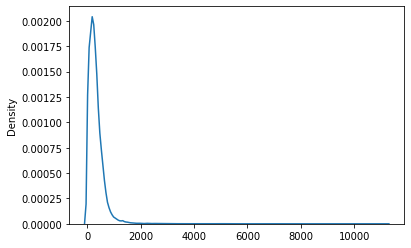

In [ ]:
word_count_X = [len(text.split()) for text in X]
sns.kdeplot(word_count_X)

<AxesSubplot:ylabel='Density'>

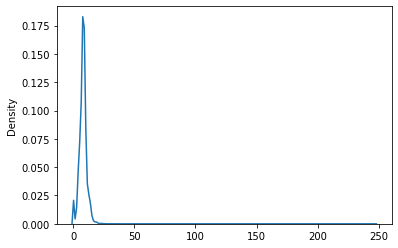

In [ ]:
word_count_y = [len(title.split()) for title in y]
sns.kdeplot(word_count_y)

From the plots above, we can see that `text` word lengths peak at about 500. We'll get rid of `texts` beyond lengths of 700. Meanwhile for `titles`, we'll get rid of data that is longer than 25 words. 

In [ ]:
clean_X = []
clean_y = []

for idx, (len_X, len_y) in enumerate(zip(word_count_X, word_count_y)):
    if (1 <= len_X <= 700) and (1 <= len_y <= 25):
        clean_X.append(X[idx])
        clean_y.append(y[idx])

## Feature extraction 
Phew! That was a lot. Now that we have cleaned text data, can we directly feed it into a ML algorithm?  
No. Computers cannot really make sense of words. We need to convert our text data into numbers.  
A good approach is to [one-hot encode](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) the data.

We'll define a `Lang` class to keep a track of `word` to `idx` mappings and vice-versa.  
Note: This code snippet has been sourced from official [PyTorch NLP tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) 


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Let's pass our cleaned `text` and `title` sequences through the `Lang` class.

In [ ]:
X_lang = Lang(clean_X)
y_lang = Lang(clean_y)

Now, we'll generate the input-output pairs and then pass them through the `addSentence` function to update the class dictionaries

In [ ]:
in_out_pairs = list(zip(clean_X, clean_y))  # generates (X,y) pairs

In [ ]:
for pair in in_out_pairs:
    X_lang.addSentence(pair[0])
    y_lang.addSentence(pair[1])

In [ ]:
# Dump data to disk
data_dump = "final_data.pkl"
with open(data_dump, "wb") as f:
    pickle.dump(data_dump, f)
print("Wrote final data to cache file:", data_dump)

So far we've learned how to extract, clean and process raw text data.  
That's it for part 1 of this series. In the next part we'll attempt to build a NLP model for text summarization.